In [356]:
!%pip install adjustText

zsh:fg:1: no job control in this shell.


In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from adjustText import adjust_text

from tqdm import tqdm
import math
import json

pd.set_option('display.max_columns', 90)
pd.options.mode.chained_assignment = None
pd.options.mode.copy_on_write = True

In [358]:
movies = pd.read_csv('data/imdb-cleaned.csv')

# Data Preparation

In [359]:
movies['total_votes'] = movies.loc[:, 'rating_1':'rating_10'].sum(axis='columns')

We made a variable `total_votes` with the total number of user votes on each movie.

In [360]:
def calc_unweighted_rating(row):
    return sum(i * row[f'rating_{i}'] for i in range(1, 11)) / row['total_votes']

movies['unweighted_rating'] = movies.apply(calc_unweighted_rating, axis='columns')

In [361]:
def calc_polarization(row):
    total_score = 0
    for rating_1 in range(1, 11):
        for rating_2 in range(rating_1 + 1, 11):
            total_score += row[f'rating_{rating_1}'] / row['total_votes'] * row[f'rating_{rating_2}'] / row['total_votes'] * (rating_2 - rating_1)

    return total_score / 2.25

In [362]:
movies['polarization_score'] = movies.apply(calc_polarization, axis='columns')

We made a variable polarization_score with the polarization score for each movie's ratings calculated using a version of Esteban and Ray's algorithm [Esteban and Ray, 1993]. The algorithm is based on the premise that polarization in a distribution is equivalent to the sum of what they call the "effective antagonisms" in that distribution. Each pair of values—the 1s and the 10s, the 1s and the 9s, and so on—have an effective antagonism, which is a function of the difference between the two values and the number of instances of each. To find the effective antagonism between two values, we multiply the proportions of scores matching those two values in the overall distribution by each other, and then multiply that by the difference between the two values. This yields a score from 0 (not polarized at all—all ratings for the film are the same) to 2.25 (extremely polarized—exactly 50% 1s and 50% 10s). We then divide by 2.25 to obtain a score between 0 and 1, in order to produce a more intuitive number for polarization.

In [363]:
def calc_country_rating(country_idx, row):
    total_rating = 0
    total_votes = 0
    for rating in range(1, 11):
        total_rating += rating * row[f'country_{country_idx}_rating_{rating}']
        total_votes += row[f'country_{country_idx}_rating_{rating}']
    return total_rating / total_votes

In [364]:
for i in range(5):
    movies[f'country_{i}_rating'] = movies.apply(lambda row: calc_country_rating(i, row), axis='columns')

We made variables `country_{0...4}_rating` with the average rating for each of the top five countries with the most votes for each movie.

In [365]:
def calc_ptp(row):
    ptp = np.ptp(row.loc['country_0_rating':'country_4_rating'])

    max_country_idx = np.argmax(row.loc['country_0_rating':'country_4_rating'])
    min_country_idx = np.argmin(row.loc['country_0_rating':'country_4_rating'])
    max_country = row[f'country_{max_country_idx}']
    min_country = row[f'country_{min_country_idx}']

    return pd.Series([ptp, max_country, min_country])

In [366]:
movies[['country_ptp', 'max_country_ptp', 'min_country_ptp']] = movies.apply(calc_ptp, axis='columns')

We made a variable `country_ptp` with the difference between the highest and lowest average ratings between the top five countries with the most votes for each movie. The variables `max_country_ptp` and `min_country_ptp` record the country codes of the two countries with the highest and lowest average ratings for each movie, respectively.

In [367]:
movies['rating_diff'] = movies['weighted_rating'] - movies['unweighted_rating']

We made a variable `rating_diff` with the difference between the weighted (by IMDb) rating and the unweighted rating for each movie.

In [368]:
movies['pct_polarized_votes'] = (movies['rating_1'] + movies['rating_10']) / movies['total_votes']

We made a variable `pct_polarized_votes` with the percentage of votes that are polarized (i.e., 1 or 10).

In [369]:
movies['genres'] = movies['genres'].str.split(',')
movies['keywords'] = movies['keywords'].str.split(',')

We split the `genres` and `keywords` columns into lists.

In [370]:
movies['keywords'] = movies['keywords'].apply(lambda keywords: keywords if isinstance(keywords, list) else [])

Replace empty `keywords` values with empty lists.

In [371]:
movies[movies['keywords'].isna()]

,id,title,genres,weighted_rating,release_year,keywords,credits,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff,pct_polarized_votes


# EDA

In [372]:
movies.sort_values('polarization_score', ascending=False).head(10)

,id,title,genres,weighted_rating,release_year,keywords,credits,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff,pct_polarized_votes
3355,tt4776998,The Promise,"[Period Drama, Action, Adventure, Drama, War]",6.1,2017,"[love triangle, armenian genocide, belly dance...","Oscar Isaac,Charlotte Le Bon,Christian Bale,Da...",71662,791,472,780,1818,4263,5899,4517,3108,86307,US,1836,95,82,183,406,1000,1349,1150,924,21034,TR,18264,365,125,92,90,103,95,43,26,504,RU,266,8,10,17,43,79,90,52,39,8779,GB,710,22,20,61,131,363,460,335,168,3350,AM,5,2,0,3,3,20,34,26,52,4503,179617,6.017910,0.979214,8.850387,1.374537,9.619098,7.972064,9.918244,8.543707,AM,TR,0.082090,0.879477
4381,tt7668842,Enes Batur: Imagination or Reality?,[Comedy],2.0,2018,[college],"Enes Batur,Baran Teyin,Egemen Erturk,Mete Güler",21589,749,532,351,478,375,437,477,501,30871,TR,14630,567,402,267,323,242,285,246,231,14038,US,369,28,19,8,12,12,7,3,5,106,AZ,108,7,7,6,7,5,2,6,5,270,GB,184,10,6,2,3,5,4,4,2,46,MY,1,0,0,1,0,0,0,0,0,176,56360,6.224645,0.972270,5.364125,3.205624,7.184397,3.056391,9.915730,6.859339,MY,GB,-4.224645,0.930802
4300,tt6277462,Brahmastra Part One: Shiva,"[Action Epic, Adventure Epic, Dark Fantasy, Su...",5.6,2022,"[fantasy superhero, non comic book superhero, ...","Amitabh Bachchan,Ranbir Kapoor,Alia Bhatt,Naga...",42092,3978,2372,2527,3661,4853,6725,6539,6942,34257,IN,34403,2969,1621,1591,2178,2874,4344,4705,5644,28733,US,3174,420,302,351,561,745,945,752,522,1803,GB,1608,193,132,173,262,391,470,389,235,948,BD,450,85,67,111,182,240,251,182,126,666,CA,504,66,39,40,58,69,79,72,70,359,113946,5.433539,0.955121,5.455480,5.113107,5.152052,6.195763,5.137168,1.082656,BD,US,0.166461,0.670045
4156,tt26932223,Bhool Bhulaiyaa 3,"[Supernatural Horror, Comedy, Fantasy, Horror]",4.6,2024,"[female ghost, supernatural horror, horror com...","Kartik Aaryan,Vidya Balan,Madhuri Dixit,Tripti...",22713,5223,4974,3771,1653,1635,1220,3437,9253,23666,IN,21381,4835,4557,3256,926,951,759,3148,9050,22967,US,386,118,129,170,231,229,149,100,71,165,GB,172,64,67,79,119,140,78,39,22,103,BD,166,46,61,73,121,92,71,52,29,97,PK,94,29,31,33,47,40,31,20,10,76,77545,5.638184,0.949444,5.703731,4.776888,4.912797,4.992574,5.058394,0.926843,IN,US,-1.038184,0.598091
4364,tt12915716,Adipurush,"[Action Epic, Epic, Action, Drama]",2.7,2023,"[ramayan, jai shree ram, ram siya ram, based o...","Prabhas,Kriti Sanon,Saif Ali Khan,Devdutta Nage",51307,3108,1592,1069,1092,1200,4079,19145,20884,32025,IN,40727,2202,1061,666,714,946,3771,18743,20506,30318,US,3480,302,200,143,158,89,159,129,166,594,GB,1792,176,95,72,58,37,50,46,111,260,BD,1122,119,61,48,40,23,11,6,6,105,NP,724,32,17,5,5,3,3,5,2,52,135501,5.676371,0.942455,6.053279,2.981365,2.797924,2.142764,1.770047,4.283231,IN,NP,-2.976371,0.614992
420

Here are the top ten movies sorted by `polarization_score` (i.e. the movies with the most polarized rating distributions).

In [373]:
movies.sort_values('rating_diff', ascending=False).head(10)

,id,title,genres,weighted_rating,release_year,keywords,credits,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff,pct_polarized_votes
4362,tt7825208,Marighella,"[Docudrama, Political Thriller, Action, Drama,...",7.1,2021,"[dictatorship, military dictatorship, fascism,...","Seu Jorge,Bruno Gagliasso,Luiz Carlos Vasconce...",38403,698,186,103,181,390,807,984,803,13959,BR,35665,635,149,67,117,274,613,783,669,12350,US,1259,23,7,19,16,28,51,59,39,445,PT,303,7,3,6,6,26,38,39,23,195,GB,221,3,3,2,6,6,9,14,11,162,CA,178,5,3,0,1,3,8,7,11,86,56514,3.615954,0.822686,3.506391,3.741007,5.063467,5.043478,4.274834,1.557076,PT,BR,3.484046,0.926531
530,tt5971474,The Little Mermaid,"[Fairy Tale, Feel-Good Romance, Sea Adventure,...",7.2,2023,"[fairy tale, little mermaid, magic spell, disn...","Halle Bailey,Jonah Hauer-King,Melissa McCarthy...",47336,8934,6351,6791,11760,19911,24827,16342,8084,21512,US,14153,2765,1967,1869,2985,5055,7360,6006,3556,10475,GB,2718,656,482,618,1120,2062,2659,1712,766,1300,CA,1477,291,221,238,403,657,910,678,350,728,BR,1265,226,179,216,419,743,821,659,286,837,DE,1540,327,258,288,503,767,871,391,180,257,171848,5.132955,0.814029,5.599420,5.543390,5.351083,5.597947,4.580453,1.018966,US,DE,2.067045,0.400633
2220,tt1289401,Ghostbusters,"[Slapstick, Supernatural Fantasy, Action, Come...",6.8,2016,"[reboot, vomiting, woman slaps a woman, femini...","Melissa McCarthy,Kristen Wiig,Kate McKinnon,Le...",44064,13155,14700,20882,33205,41408,34198,19356,8400,23757,US,12686,3673,3837,5172,8194,10943,10832,7116,3267,7740,GB,4756,1596,1921,2590,4044,5461,4818,2611,924,1857,CA,1585,604,607,780,1288,1643,1496,918,390,829,DE,1595,591,786,1064,1580,1740,1264,521,178,320,SE,1415,447,480,741,1236,1305,887,452,173,1154,253125,5.214337,0.705033,5.423550,5.185329,5.290730,4.725490,5.264777,0.698060,US,DE,1.585663,0.267935
4214,tt10083340,Gangubai Kathiawadi,"[True Crime, Biography, Crime, Drama]",7.8,2022,"[underworld, based on real people, life, teena...","Alia Bhatt,Shantanu Maheshwari,Vijay Raaz,Indi...",16477,1161,766,858,1536,3106,6637,7568,4371,21685,IN,12219,778,467,487,779,1396,2760,3352,2166,16910,US,1852,166,114,128,253,522,1113,1251,672,2131,GB,1144,86,61,58,131,290,694,783,404,688,BD,153,16,22,36,62,152,339,311,159,315,PK,51,7,12,15,37,80,162,188,105,182,64165,6.452692,0.876433,6.393111,6.412095,5.937774,7.066454,7.424315,1.486541,PK,GB,1.347308,0.594748
4209,tt10028196,Laal Singh Chaddha,"[Epic, Comedy, Drama, Romance]",5.6,2022,"[indian remake of american film, foreign langu...","Aamir Khan,Ahmad Ibn Umar,Kareena Kapoor,Hafsa...",97797,4268,1443,980,1516,2503,3573,7483,14417,45561,IN,84288,3318,985,501,650,962,1492,5377,12767,35389,US,5679,406,161,152,231,397,573,615,470,2529,GB,3086,192,83,74,147,223,318,362,274,1336,

Here are the top ten movies sorted by `rating_diff` (i.e. the movies to which IMDb made the largest positive rating adjustments).

In [374]:
movies.sort_values('pct_polarized_votes', ascending=False).head(10)

,id,title,genres,weighted_rating,release_year,keywords,credits,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff,pct_polarized_votes
4371,tt5988370,Reis,"[Biography, Drama]",1.0,2017,"[turk, prime minister, president]","Orhan Aydin,Özlem Balci,Volkan Basaran,Reha Be...",59782,237,63,42,77,47,52,61,115,13845,TR,37498,148,41,24,38,24,29,32,75,7991,US,2074,15,4,3,3,1,3,2,0,141,DE,750,3,0,0,2,3,1,3,1,291,GB,977,5,1,1,1,1,1,0,4,62,NL,268,1,0,0,0,0,0,0,0,169,74321,2.712786,0.616340,2.601111,1.601069,3.542694,1.584046,4.474886,2.890840,NL,GB,-1.712786,0.990662
4379,tt7886848,Sadak 2,"[Action, Drama]",1.2,2020,"[running, sequel]","Sanjay Dutt,Alia Bhatt,Aditya Roy Kapoor,Jissh...",92021,572,346,267,319,273,263,244,243,2435,IN,69919,317,172,132,162,153,152,141,151,1582,US,9572,104,77,41,60,44,36,37,27,261,GB,5615,46,35,37,28,26,23,15,19,153,BD,1308,17,13,12,15,10,9,9,5,69,CA,1038,5,5,2,6,2,5,5,1,22,96983,1.328418,0.140376,1.271882,1.378302,1.373687,1.659168,1.298808,0.387287,BD,IN,-0.128418,0.973944
4176,tt10811166,The Kashmir Files,"[Political Drama, Tragedy, Drama]",8.5,2022,"[kashmiri pandit, genocide, brutality, massacr...","Mithun Chakraborty,Anupam Kher,Darshan Kumaar,...",32066,1563,914,753,1189,1477,2516,4314,9290,522190,IN,22473,1055,598,478,770,896,1626,2912,6887,442789,US,2729,186,134,102,180,241,377,628,1129,35853,GB,1653,96,47,55,65,125,197,342,656,21444,BD,1501,50,29,18,40,36,63,83,80,2867,CA,398,20,13,14,15,19,30,51,80,3990,576272,9.393805,0.250763,9.494730,9.206453,9.227715,6.853577,9.062635,2.641154,IN,BD,-0.893805,0.961796
4365,tt10554232,Dara of Jasenovac,"[Drama, War]",8.1,2021,[genocide of serbs in the independent state of...,"Biljana Cekic,Zlatan Vidovic,Anja Stanic,Luka ...",3822,262,176,201,350,563,951,1228,1533,73046,RS,190,54,53,72,97,153,222,349,774,46347,BA,813,47,20,13,22,24,21,33,69,9282,US,204,13,16,15,48,58,104,125,145,2952,ME,52,3,3,2,6,7,13,19,37,3100,HR,1762,74,32,31,39,26,31,24,12,449,82132,9.393951,0.249525,9.872079,9.196152,9.097554,9.785009,3.019355,6.852724,RS,HR,-1.293951,0.935908
6,tt6208148,Snow White,"[Fairy Tale, Feel-Good Romance, Adventure, Fam...",1.6,2025,"[narcissism, hag, dystopia, tyrant, female vil...","Rachel Zegler,Emilia Faucher,Gal Gadot,Andrew ...",315657,6400,2314,2008,2507,2846,2949,2483,1446,11564,US,81701,2123,682,552,709,906,1117,996,550,3540,GB,21245,403,211,211,284,337,366,285,151,865,BR,12106,272,113,99,105,91,74,69,46,373,CA,10590,191,73,63,64,85,105,126,61,389,IN,11181,109,41,21,35,25,26,22,34,204,350174,1.548382,0.227233,1.672327,1.716931,1.473629,1.571039,1.251069,0.465862,GB,IN,0.051618,0.934453
4381,tt7668842,Enes Batur: Imagination or Reality?,[Comedy],2.0,2018,[college],"Enes Batur,Baran Teyin,Egemen Erturk,Mete Güler",21589,749,532,351,478,375,437,47

Here are the top ten movies sorted by `pct_polarized_votes` (i.e. the movies with the largest percentage of polarized votes).

In [375]:
movies[['weighted_rating', 'unweighted_rating', 'rating_diff', 'polarization_score', 'pct_polarized_votes']].describe()

,weighted_rating,unweighted_rating,rating_diff,polarization_score,pct_polarized_votes
count,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000
mean,6.820698,6.953211,-0.132513,0.417261,0.130152
std,0.908655,0.869225,0.217734,0.076517,0.097511
min,1.000000,1.328418,-4.224645,0.140376,0.037033
25%,6.300000,6.429873,-0.189712,0.365990,0.078159
50%,6.900000,7.019264,-0.119491,0.405768,0.103773
75%,7.500000,7.583574,-0.051256,0.451245,0.144590
max,9.300000,9.393951,3.484046,0.979214,0.990662


Here are the summary statistics for the numeric variables in the dataset.

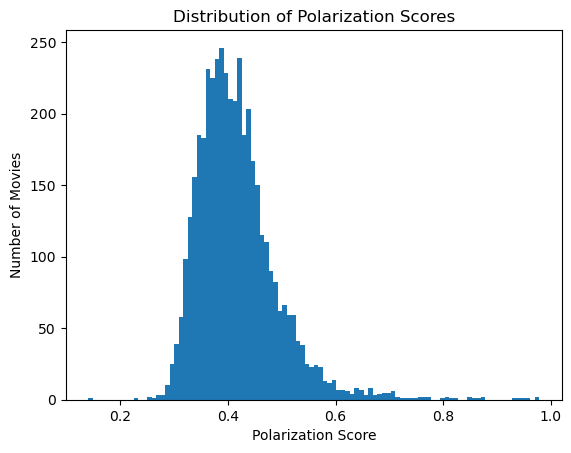

In [376]:
plt.hist(movies['polarization_score'], bins=100)
plt.xlabel('Polarization Score')
plt.ylabel('Number of Movies')
plt.title('Distribution of Polarization Scores')
plt.show()

The distribution of polarization scores is somewhat right-skewed, centered approximately around 0.4.

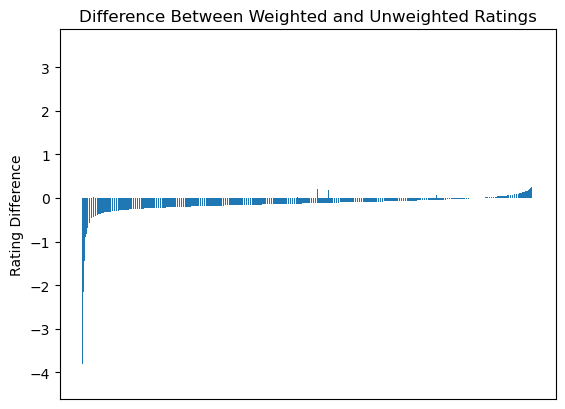

In [377]:
df_to_plot = movies.sort_values('rating_diff', ascending=True)

plt.bar(df_to_plot['title'], df_to_plot['rating_diff'])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Rating Difference')
plt.title('Difference Between Weighted and Unweighted Ratings')
plt.show()

The distribution of rating difference shows that IMDb's weighting algorithm tends to yield lower scores than the unweighted ratings, with some exceptions. Most films' ratings are adjusted by tenths of a point or less, although some, visible on the ends of the distribution, have their ratings drastically altered by the algorithm.

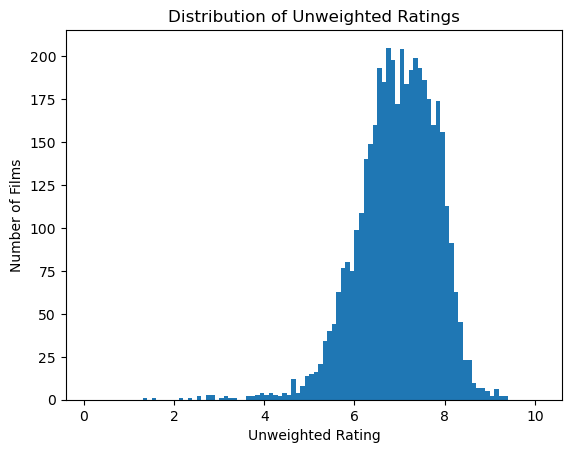

In [378]:
#define bins at each hundredth between 0 and 10
my_bins = [0.1]
for i in range(100):
    my_bins.append(my_bins[i] + 0.1)

plt.hist(movies['unweighted_rating'], bins=my_bins)
plt.xlabel('Unweighted Rating')
plt.ylabel('Number of Films')
plt.title('Distribution of Unweighted Ratings')
plt.show()

The distribution of unweighted ratings is left-skewed and centered approximately around 7.

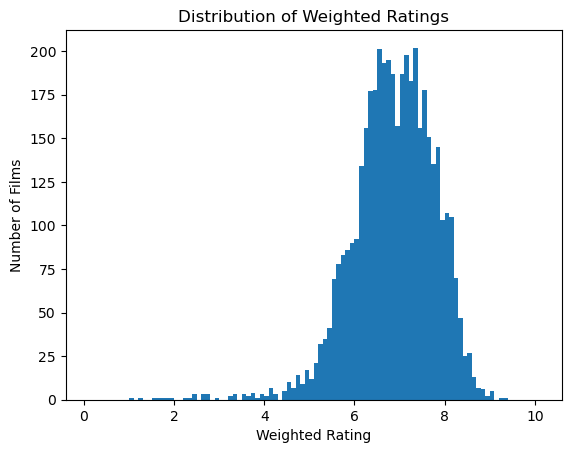

In [379]:
plt.hist(movies['weighted_rating'], bins=my_bins)
plt.xlabel('Weighted Rating')
plt.ylabel('Number of Films')
plt.title('Distribution of Weighted Ratings')
plt.show()

The distribution of weighted ratings looks very similar—it is also left-skewed and has a center of close to 7. However, on closer examination, it is clear that this distribution has a slightly lower center as a result of the algorithm's tendency to slightly lower ratings.

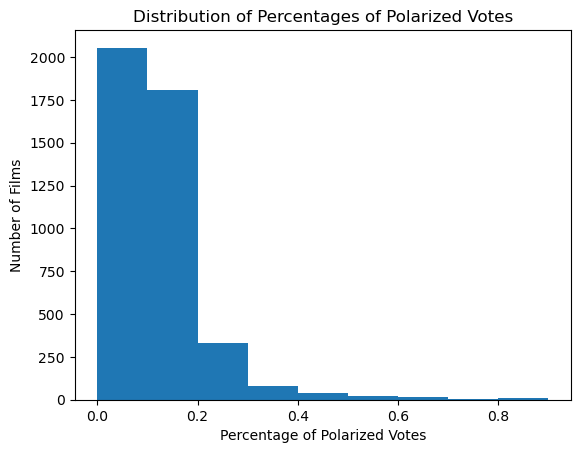

In [380]:
plt.hist(movies['pct_polarized_votes'], bins=np.arange(0.0, 1.0, 0.1))
plt.xlabel('Percentage of Polarized Votes')
plt.ylabel('Number of Films')
plt.title('Distribution of Percentages of Polarized Votes')
plt.show()

The distribution of the percentage polarized votes is highly right-skewed, with almost all movies having fewer than 20% polarized votes.

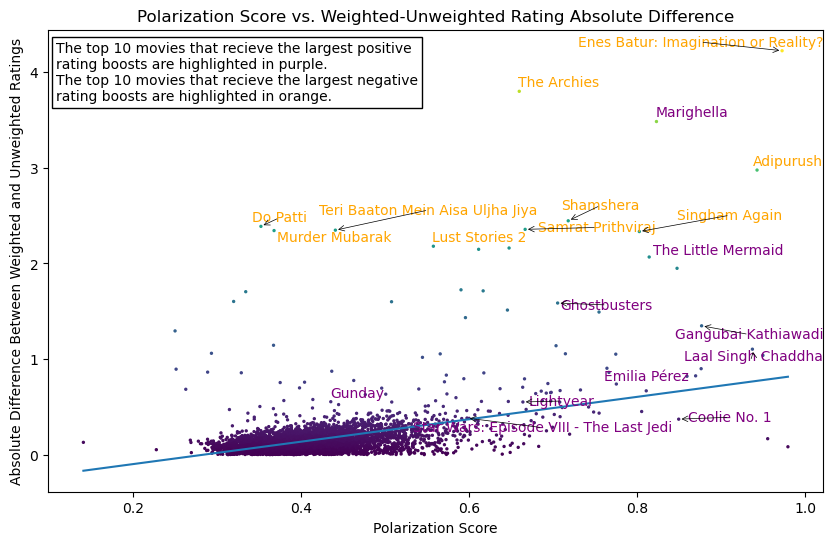

In [381]:
df_to_plot = movies.sort_values('rating_diff', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(movies['polarization_score'], movies['rating_diff'].abs(), s=2, c=movies['rating_diff'].abs(), cmap='viridis')

texts = []
for i, movie in enumerate(df_to_plot.tail(10).itertuples()):
    texts.append(ax.text(movie.polarization_score, abs(movie.rating_diff), movie.title, color='purple'))

for i, movie in enumerate(df_to_plot.head(10).itertuples()):
    texts.append(ax.text(movie.polarization_score, abs(movie.rating_diff), movie.title, color='orange'))


adjust_text(texts, autoalign='xy', 
            expand_points=(1.2, 1.2), 
            arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

text_str = 'The top 10 movies that recieve the largest positive\nrating boosts are highlighted in purple.\nThe top 10 movies that recieve the largest negative\nrating boosts are highlighted in orange.'
props = dict(boxstyle='square', facecolor='white')
ax.text(0.01, 0.975, text_str, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left', bbox=props)

ax.plot(np.unique(movies['polarization_score']), np.poly1d(np.polyfit(movies['polarization_score'], movies['rating_diff'].abs(), 1))(np.unique(movies['polarization_score'])))
plt.ylabel('Absolute Difference Between Weighted and Unweighted Ratings')
plt.xlabel('Polarization Score')
plt.title('Polarization Score vs. Weighted-Unweighted Rating Absolute Difference')
plt.show()

In general, it seems as though films with higher polarization scores are more likely to have their ratings heavily adjusted by IMDb's weighting algorithm (positive correlation between absolute rating difference and polarization score).

In [382]:
movies['polarization_score'].corr(movies['rating_diff'].abs())

0.44507407806397126

In [449]:
x = movies['polarization_score']
y = movies['rating_diff'].abs()

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rating_diff   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     1082.
Date:                Tue, 13 May 2025   Prob (F-statistic):          2.93e-212
Time:                        12:42:37   Log-Likelihood:                 1286.6
No. Observations:                4382   AIC:                            -2569.
Df Residuals:                    4380   BIC:                            -2556.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.3329      0.015    -22.025      0.000      -0.363      -0.303
polarization_score     1.1720      0.036     32.893      0.000       1.102       1.242
==============================================================================
Omnibus:                     6261.124   Durbin-Watson:                   1.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2425469.194
Skew:                           8.372   Prob(JB):                         0.00
Kurtosis:                     117.034   Cond. No.                         15.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a moderate positive correlation between `polarization_score` and absolute `rating_diff`. On average, a movie with a `polarization_score` of 1 has an absolute `rating_diff` 1.172 greater than a movie with a `polarization_score` of 0. The r-squared is 0.198, indicating that 19.98% of the variance in `rating_diff` can be explained by `polarization_score`.

## IMDb's Weighting Algorithm

In [384]:
ovr_avg_rating_diff = movies['rating_diff'].mean()

What kinds of movies does IMDb's weighting algorithm boost or de-boost?

Here, we calculate an `avg_rating_boost`, broken down by genre and keyword. The rating boost is calculated by comparing the how much the rating for a movie tagged with a specific genre or keyword is increased/decreased by IMDb's algorithm, on average, compared to a how much the alogrithm increases/decreases movie ratings overall on average (`ovr_avg_rating_diff`). A positive value indicates that the algorithm tends to boost ratings for that genre or keyword, while a negative value indicates that the algorithm tends to de-boost ratings for that genre or keyword.

In [385]:
genres_weighting_data = []

all_genres = movies['genres'].explode()
genre_counts = all_genres.value_counts()
top_genres = genre_counts[genre_counts > 100].index.tolist()

for genre in top_genres:
    genre_movies = movies[movies['genres'].apply(lambda x: genre in x)]
    cum_rating_diff = genre_movies['rating_diff'].sum()
    num_movies = len(genre_movies)
    avg_rating_diff = cum_rating_diff / num_movies
    genres_weighting_data.append({
        'genre': genre,
        'avg_rating_boost': avg_rating_diff - ovr_avg_rating_diff,
        'num_movies': num_movies
    })

genres_weighting_df = pd.DataFrame(genres_weighting_data)

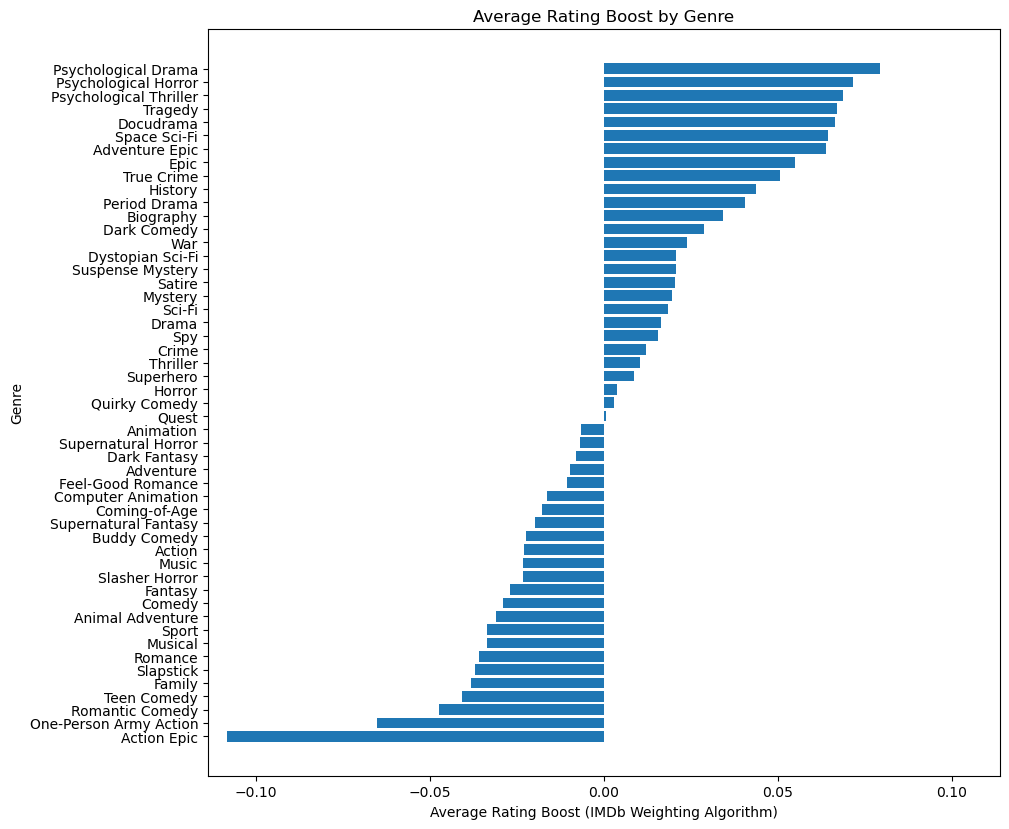

In [386]:
genres_weighting_df = genres_weighting_df.sort_values('avg_rating_boost', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(genres_weighting_df['genre'], genres_weighting_df['avg_rating_boost'])
max_abs_value = genres_weighting_df['avg_rating_boost'].abs().max() * 1.05
plt.xlim(-max_abs_value, max_abs_value)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.ylabel('Genre')
plt.xlabel('Average Rating Boost (IMDb Weighting Algorithm)')
plt.title('Average Rating Boost by Genre')
plt.show()

In [387]:
genres_weighting_df.sort_values('avg_rating_boost', ascending=False).head(50)

,genre,avg_rating_boost,num_movies
16,Psychological Drama,0.079493,278
43,Psychological Horror,0.071601,109
19,Psychological Thriller,0.068664,249
15,Tragedy,0.067041,299
23,Docudrama,0.066562,196
42,Space Sci-Fi,0.064537,112
45,Adventure Epic,0.063764,108
28,Epic,0.054997,153
46,True Crime,0.050598,108
25,History,0.043685,176


Genres associated with more politically controversial subject material (e.g. "War", "Period Drama", "Docudrama", "History", "Biography", "Satire") as well as genres more likely to have violent or non-culturally normative themes (e.g. "Psychological Drama", "Psychological Thriller", "True Crime", "Dark Comedy", "Dystopian Sci-fi") are among those boosted most by IMDb's weighting algorithm. Genres associated with more mainstream, family-friendly, or culturally normative themes (e.g. "Family", "Romance", "Musical", "Romantic Drama", "Slapstick", "Sport", "Action Epic", "Animal Adventure", "Comedy", "Fantasy", "") are among those de-boosted most by the algorithm. This suggests that the algorithm is more likely to boost ratings for films with more controversial subject matter, while de-boosting ratings for films with more mainstream or family-friendly themes. This is consistent with the idea that IMDb's weighting algorithm is designed to reduce the influence of unrepresentative user ratings on the overall rating, which may be more likely to be positive for films with more mainstream or family-friendly themes and more negative for films with more controversial subject matter.

In [388]:
keywords_weighting_data = []

all_keywords = movies['keywords'].explode()
keyword_counts = all_keywords.value_counts()
top_keywords = keyword_counts[keyword_counts > 30].index.tolist()

for keyword in top_keywords:
    keyword_movies = movies[movies['keywords'].apply(lambda x: keyword in x)]
    cum_rating_diff = keyword_movies['rating_diff'].sum()
    num_movies = len(keyword_movies)
    avg_rating_diff = cum_rating_diff / num_movies
    keywords_weighting_data.append({
        'keyword': keyword,
        'avg_rating_boost': avg_rating_diff - ovr_avg_rating_diff,
        'num_movies': num_movies
    })

keywords_weighting_df = pd.DataFrame(keywords_weighting_data)

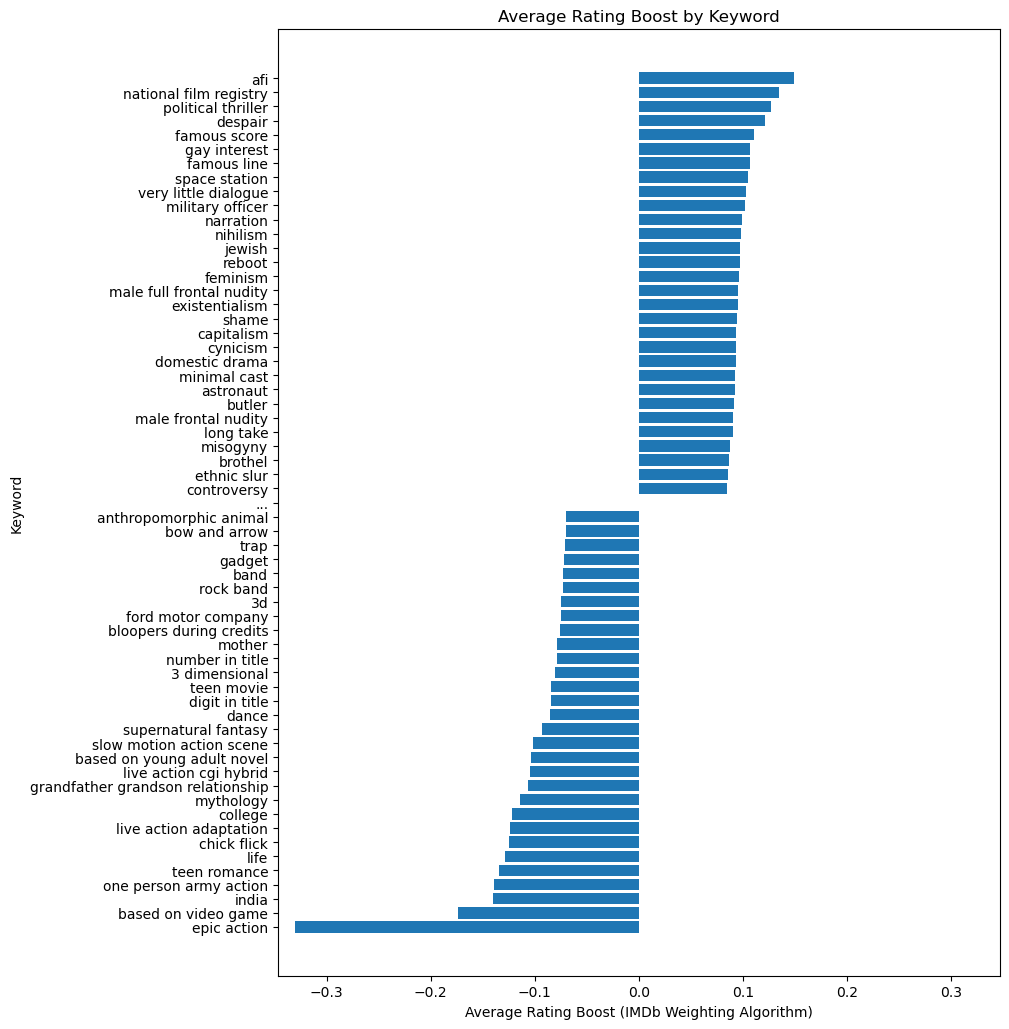

In [389]:
keywords_weighting_df = keywords_weighting_df.sort_values('avg_rating_boost', ascending=True)

df_to_plot = pd.concat((
    keywords_weighting_df.head(30),
    pd.DataFrame([{'keyword': '...', 'avg_rating_boost': 0}]),
    keywords_weighting_df.tail(30)
))

plt.figure(figsize=(10, 10))
plt.barh(df_to_plot['keyword'], df_to_plot['avg_rating_boost'])
max_abs_value = df_to_plot['avg_rating_boost'].abs().max() * 1.05
plt.xlim(-max_abs_value, max_abs_value)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.ylabel('Keyword')
plt.xlabel('Average Rating Boost (IMDb Weighting Algorithm)')
plt.title('Average Rating Boost by Keyword')
plt.show()

In [390]:
keywords_weighting_df.sort_values('avg_rating_boost', ascending=False).head(30)

,keyword,avg_rating_boost,num_movies
1651,afi,0.149139,41
157,national film registry,0.134642,227
1291,political thriller,0.127126,50
1261,despair,0.121558,52
378,famous score,0.110519,132
1645,gay interest,0.107173,41
676,famous line,0.106958,88
1633,space station,0.105271,41
1667,very little dialogue,0.103367,41
1307,military officer,0.101904,50


Keywords associated with more high-brow movies (e.g. "afi", "national film registry", "very little dialogue", "symbolism") as well as will controversial subject material (e.g. "political thriller", "gay interest", "jewish", "capitalism", "feminism", "military officer", "male frontal nudity", "misogyny", "brothel", "ethnic slur", "alienation") are among those boosted most by IMDb's weighting algorithm.

In [391]:
keywords_weighting_df.sort_values('avg_rating_boost', ascending=True).head(30)

,keyword,avg_rating_boost,num_movies
1264,epic action,-0.330089,52
1840,based on video game,-0.173687,36
1365,india,-0.140134,48
916,one person army action,-0.139312,67
1281,teen romance,-0.134593,51
1992,life,-0.128105,34
1808,chick flick,-0.125081,37
2029,live action adaptation,-0.123424,33
597,college,-0.121909,97
1766,mythology,-0.114400,38


Keywords associated with more mainstream movies ("epic action", "based on video game", "teen romance", "chick flick", "college", "live action adaptation", "based on young adult novel", "teen movie") are among those boosted least by IMDb's weighting algorithm.

## Effect of Weighting Algorithms on a Hypothetical Recommendation Algorithm

In [392]:
def naive(movie, movies_not_me, rating_column):
    movie_keywords = set(movie.keywords)

    matching_keyword_score = movies_not_me['keywords'].apply(lambda x: len(movie_keywords.intersection(set(x)))) / len(movie_keywords) * 10
    rating_score = movies_not_me[rating_column]

    recommendation_score = matching_keyword_score * rating_score

    return recommendation_score


def recommendation_algo(movies, rating_column, algo=naive):
    recommendation_data = pd.DataFrame({
        'title': movies['title'],
        'num_recommendations': 0,
    })

    for _, movie in tqdm(
        enumerate(movies.itertuples()),
        desc=f'recommending movies using "{rating_column}" ...',
        total=len(movies)
    ):
    # for _, movie in enumerate(movies.itertuples()):
        movies_not_me = movies[movies.index != movie.Index]

        recommendation_score = naive(movie, movies_not_me, rating_column)
        recommendation_score.sort_values(ascending=False, inplace=True)
        top_movies = movies.loc[recommendation_score.index]

        recommendation_data.loc[recommendation_data.index.isin(top_movies.head(10).index), 'num_recommendations'] += 1

    return recommendation_data

In [393]:
weighted_recommendation_data = recommendation_algo(movies, 'weighted_rating')
unweighted_recommendation_data = recommendation_algo(movies, 'unweighted_rating')

recommending movies using "weighted_rating" ...: 100%|██████████| 4382/4382 [01:35<00:00, 45.83it/s]
recommending movies using "unweighted_rating" ...: 100%|██████████| 4382/4382 [01:37<00:00, 44.89it/s]


In [394]:
def diff_recommendation_data(reccommendation_data, other_recommendation_data):
    diffed_recommendation_data = reccommendation_data.copy()
    diffed_recommendation_data['num_recommendations'] -= other_recommendation_data['num_recommendations']
    diffed_recommendation_data.rename(columns={'num_recommendations': 'num_recommendations_diff'}, inplace=True)
    diffed_recommendation_data['num_recommendations_diff_pct'] = diffed_recommendation_data['num_recommendations_diff'] / other_recommendation_data.loc[diffed_recommendation_data.index]['num_recommendations']

    return diffed_recommendation_data

In [395]:
weighted_unweighted_diffed_recommendation_data = diff_recommendation_data(weighted_recommendation_data, unweighted_recommendation_data)

In [507]:
def plot_diff_recommendation_data(diffed_recommendation_data, rating_column_name, other_rating_column_name):
    df_to_plot = diffed_recommendation_data.sort_values('num_recommendations_diff', ascending=True)

    df_to_plot = pd.concat((
        df_to_plot.head(30),
        pd.DataFrame([{'title': '...', 'num_recommendations_diff': 0}]),
        df_to_plot.tail(30)
    ))

    plt.figure(figsize=(10, 10))
    plt.barh(df_to_plot.apply(lambda x: f'{x["title"]} ({movies.loc[x.name]["release_year"]})', axis=1), df_to_plot['num_recommendations_diff'])
    max_abs_value = df_to_plot['num_recommendations_diff'].abs().max() * 1.05
    plt.xlim(-max_abs_value, max_abs_value)
    plt.tick_params(axis='y', which='major', labelsize=10)
    plt.tight_layout()
    plt.ylabel('Movie Title')
    plt.xlabel(f'Change in Number of Recommendations ({rating_column_name} vs. {other_rating_column_name})')
    plt.title('Change in Number of Recommendations by Movie')
    plt.show()

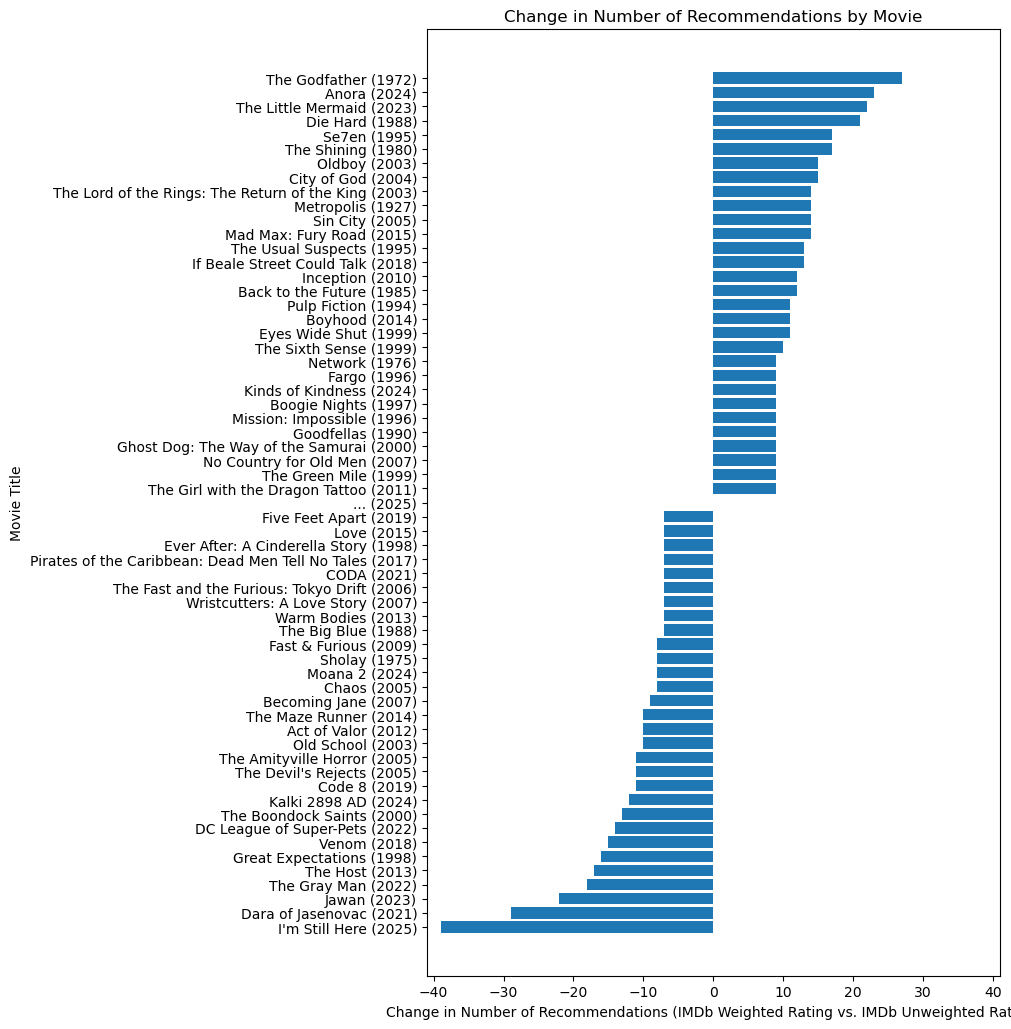

In [508]:
plot_diff_recommendation_data(weighted_unweighted_diffed_recommendation_data, 'IMDb Weighted Rating', 'IMDb Unweighted Rating')

In [ ]:
weighted_unweighted_diffed_recommendation_data.sort_values('num_recommendations_diff_pct', ascending=False).head(50)

,title,num_recommendations_diff,num_recommendations_diff_pct
3858,It's Kind of a Funny Story,1,inf
4082,Sunrise,1,inf
3405,Elle,1,inf
1000,Blue Valentine,1,inf
3742,Eye in the Sky,1,inf
3332,The Bling Ring,1,inf
1676,The Ninth Gate,1,inf
962,Apostle,1,inf
4224,The Boxtrolls,1,inf
541,Eden Lake,1,inf


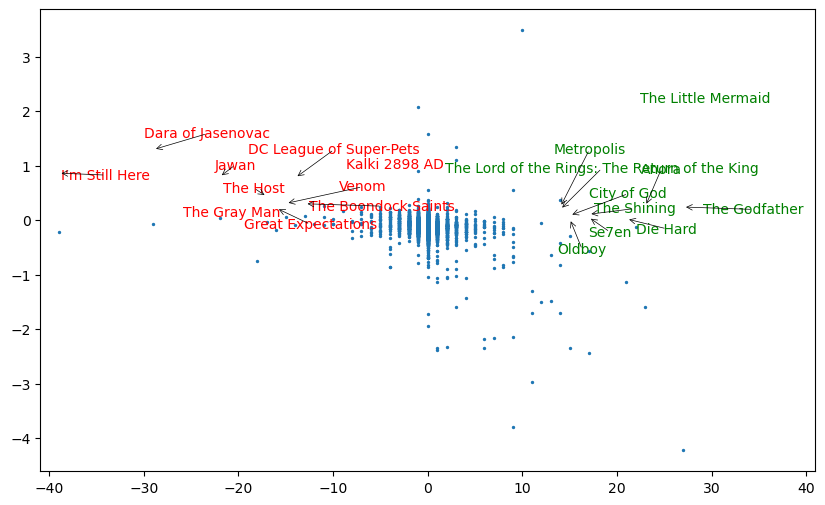

In [402]:
df_to_plot = weighted_unweighted_diffed_recommendation_data.sort_values('num_recommendations_diff', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    df_to_plot['num_recommendations_diff'],
    movies.loc[weighted_unweighted_diffed_recommendation_data.index]['rating_diff'],
    s=2
)
max_abs_value = df_to_plot['num_recommendations_diff'].abs().max() * 1.05
plt.xlim(-max_abs_value, max_abs_value)

texts = []
for i, movie in enumerate(df_to_plot.tail(10).itertuples()):
    texts.append(ax.text(movie.num_recommendations_diff, abs(movies.loc[movie.Index]['rating_diff']), movie.title, color='green'))

for i, movie in enumerate(df_to_plot.head(10).itertuples()):
    texts.append(ax.text(movie.num_recommendations_diff, abs(movies.loc[movie.Index]['rating_diff']), movie.title, color='red'))


adjust_text(texts, autoalign='xy', 
            expand_points=(1.2, 1.2), 
            arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

plt.show()

In [403]:
def calc_unpolarized_rating(row):
    return sum(i * row[f'rating_{i}'] for i in range(2, 10)) / sum(row[f'rating_{i}'] for i in range(2, 10))

movies['unpolarized_rating'] = movies.apply(calc_unpolarized_rating, axis='columns')

In [405]:
unpolarized_recommendation_data = recommendation_algo(movies, 'unpolarized_rating')

recommending movies using "unpolarized_rating" ...: 100%|██████████| 4382/4382 [01:34<00:00, 46.32it/s]


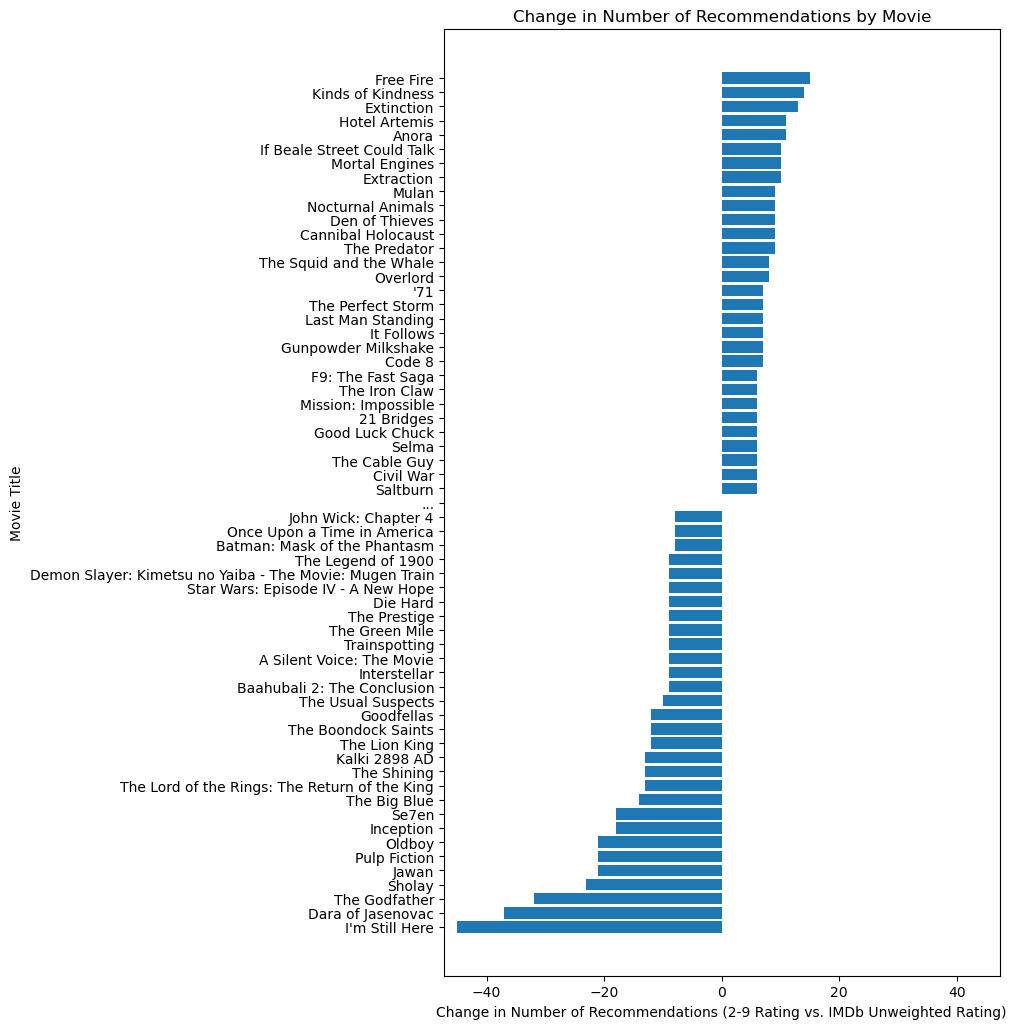

In [406]:
unpolarized_unweighted_diffed_recommendation_data = diff_recommendation_data(unpolarized_recommendation_data, unweighted_recommendation_data)
plot_diff_recommendation_data(unpolarized_unweighted_diffed_recommendation_data, '2-9 Rating', 'IMDb Unweighted Rating')

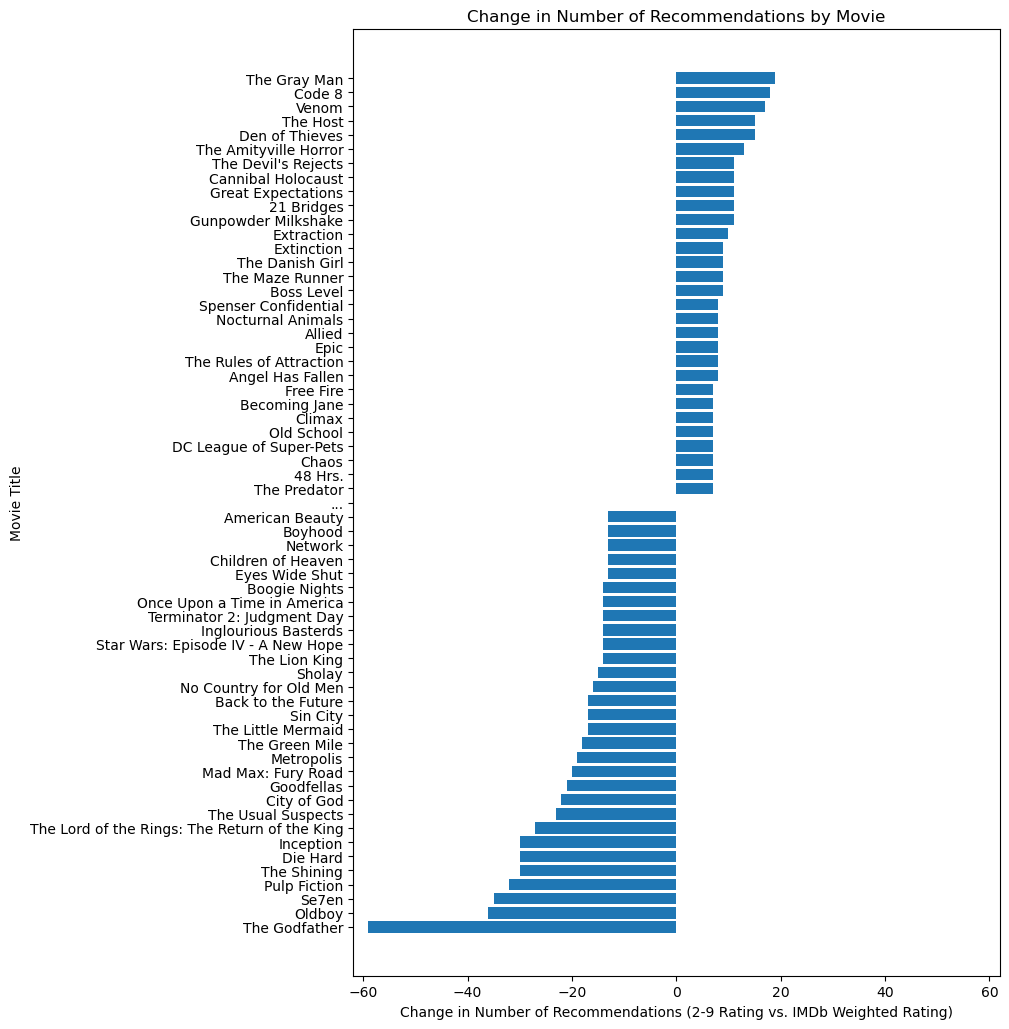

In [407]:
unpolarized_weighted_diffed_recommendation_data = diff_recommendation_data(unpolarized_recommendation_data, weighted_recommendation_data)
plot_diff_recommendation_data(unpolarized_weighted_diffed_recommendation_data, '2-9 Rating', 'IMDb Weighted Rating')

## Cast Diversity

In [408]:
race = pd.read_csv('data/actor_race_top90.tsv', sep='\t', names=['actor_id', *(f'race_{i}' for i in range(1, 11)), 'num_participants', 'unknown', 'final_race'])
gender = pd.read_csv('data/wikidata.actor.historical.gender.tsv', sep='\t', names=['actor_id', 'name', 'gender'])
gender['gender'] = gender['gender'].apply(lambda x: list(json.loads(x).values())[-1])
race_gender = pd.merge(gender, race, on='actor_id', how='outer')
race_gender = race_gender.set_index('actor_id')

In [409]:
movies['credits'] = movies['credits'].str.split(',')

In [410]:
movies['credits'] = movies['credits'].apply(lambda credits: credits if isinstance(credits, list) else [])

In [411]:
def name_to_actor_id(name: str) -> str:
    sub_df = race_gender[race_gender['name'] == name]
    if len(sub_df) == 0:
        return None
    return sub_df.iloc[0].name

movies['credits'] = movies['credits'].apply(lambda credits: list(map(name_to_actor_id, credits)))

In [412]:
movies['credits'] = movies['credits'].apply(lambda credits: list(filter(lambda x: x is not None, credits)))

In [413]:
movies_with_credits = movies.loc[movies['credits'].map(lambda x: len(x) > 0)]

In [414]:
movies_with_credits['credit_genders'] = movies_with_credits['credits'].apply(lambda credits: list(map(lambda x: race_gender.loc[x]['gender'], credits)))
movies_with_credits['credit_races'] = movies_with_credits['credits'].apply(lambda credits: list(filter(lambda x: type(x) is str, map(lambda x: race_gender.loc[x]['final_race'], credits))))

In [446]:
movies_with_credits['nonwhite_prop'] = movies_with_credits['credit_races'].apply(lambda x: 1 - x.count('White (w)') / len(x) if len(x) > 0 else pd.NA)
movies_with_credits['female_prop'] = movies_with_credits['credit_genders'].apply(lambda x: x.count('female') / len(x) if len(x) > 0 else pd.NA)

In [447]:
movies_with_race_credits = movies_with_credits.dropna(subset=['nonwhite_prop'])
movies_with_gender_credits = movies_with_credits.dropna(subset=['female_prop'])
movies_with_race_credits['nonwhite_prop'] = movies_with_race_credits['nonwhite_prop'].astype('float')

In [438]:
nonwhite_props = movies_with_race_credits['nonwhite_prop'].unique()
nonwhite_props.sort()

data_to_plot = []

for nonwhite_prop in nonwhite_props:
    data_to_plot.append(movies_with_race_credits[movies_with_race_credits['nonwhite_prop'] == nonwhite_prop]['rating_diff'])

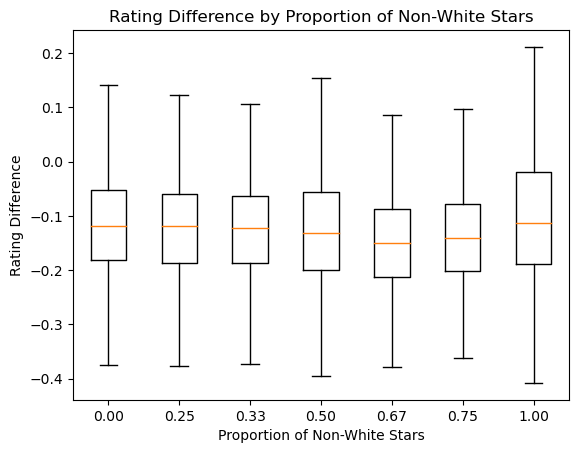

In [439]:
plt.boxplot(data_to_plot, labels=list(map(lambda x: f'{x:.2f}', nonwhite_props)), showfliers=False)
plt.xlabel('Proportion of Non-White Stars')
plt.ylabel('Rating Difference')
plt.title('Rating Difference by Proportion of Non-White Stars')
plt.show()

In [ ]:
female_props = movies_with_gender_credits['female_prop'].unique()
female_props.sort()

data_to_plot = []

for female_prop in female_props:
    data_to_plot.append(movies_with_gender_credits[movies_with_gender_credits['female_prop'] == female_prop]['rating_diff'].abs())

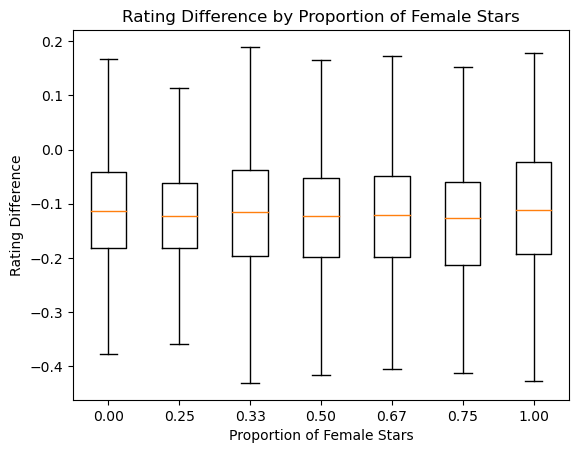

In [435]:
plt.boxplot(data_to_plot, labels=list(map(lambda x: f'{x:.2f}', female_props)), showfliers=False)
plt.xlabel('Proportion of Female Stars')
plt.ylabel('Rating Difference')
plt.title('Rating Difference by Proportion of Female Stars')
plt.show()

In [ ]:
x = movies_with_race_credits[['nonwhite_prop', 'female_prop']]
y = movies_with_race_credits['rating_diff']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     polarization_score   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     88.46
Date:                Tue, 13 May 2025   Prob (F-statistic):           2.60e-38
Time:                        12:47:57   Log-Likelihood:                 5003.2
No. Observations:                3964   AIC:                        -1.000e+04
Df Residuals:                    3961   BIC:                            -9982.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3908      0.002    185.075      0.000       0.387       0.395
nonwhite_prop     0.0290      0.004      7.782      0.000       0.022       0.036
female_prop       0.0512      0.005     11.076      0.000       0.042       0.060
==============================================================================
Omnibus:                     1022.907   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3678.033
Skew:                           1.256   Prob(JB):                         0.00
Kurtosis:                       6.995   Cond. No.                         4.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [451]:
x = movies_with_race_credits[['nonwhite_prop', 'female_prop']]
y = movies_with_race_credits['polarization_score']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     polarization_score   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     88.46
Date:                Tue, 13 May 2025   Prob (F-statistic):           2.60e-38
Time:                        12:48:17   Log-Likelihood:                 5003.2
No. Observations:                3964   AIC:                        -1.000e+04
Df Residuals:                    3961   BIC:                            -9982.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3908      0.002    185.075      0.000       0.387       0.395
nonwhite_prop     0.0290      0.004      7.782      0.000       0.022       0.036
female_prop       0.0512      0.005     11.076      0.000       0.042       0.060
==============================================================================
Omnibus:                     1022.907   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3678.033
Skew:                           1.256   Prob(JB):                         0.00
Kurtosis:                       6.995   Cond. No.                         4.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [521]:
genders = gender['gender'].value_counts().head(2).index.tolist()
races = race['final_race'].value_counts().head(15).index.tolist()

weighted_unweighted_diffed_gender_recommendation_df = pd.DataFrame({
    'gender': genders,
    'num_recommendations_diff': 0,
})

weighted_unweighted_diffed_race_recommendation_df = pd.DataFrame({
    'race': races,
    'num_recommendations_diff': 0,
})

weighted_unweighted_diffed_intersectional_recommendation_df = pd.DataFrame({
    'race': np.repeat(races, len(genders)),
    'gender': np.tile(genders, len(races)),
    'num_recommendations_diff': 0,
})

for title in weighted_unweighted_diffed_recommendation_data.itertuples():
    stars = movies.loc[title.Index]['credits']
    for star in stars:
        star_gender = None
        star_race = None

        sub_df = gender[gender['actor_id'] == star]
        if len(sub_df) != 0:
            star_gender = sub_df.iloc[0]['gender']

        sub_df = race[race['actor_id'] == star]
        if len(sub_df) != 0:
            star_race = sub_df.iloc[0]['final_race']

        if star_gender is not None:
            weighted_unweighted_diffed_gender_recommendation_df.loc[weighted_unweighted_diffed_gender_recommendation_df['gender'] == star_gender, 'num_recommendations_diff'] += title.num_recommendations_diff

        if star_race is not None:
            weighted_unweighted_diffed_race_recommendation_df.loc[weighted_unweighted_diffed_race_recommendation_df['race'] == star_race, 'num_recommendations_diff'] += title.num_recommendations_diff

        if star_gender is not None and star_race is not None:
            weighted_unweighted_diffed_intersectional_recommendation_df.loc[
                (weighted_unweighted_diffed_intersectional_recommendation_df['gender'] == star_gender) &
                (weighted_unweighted_diffed_intersectional_recommendation_df['race'] == star_race)
            , 'num_recommendations_diff'] += title.num_recommendations_diff

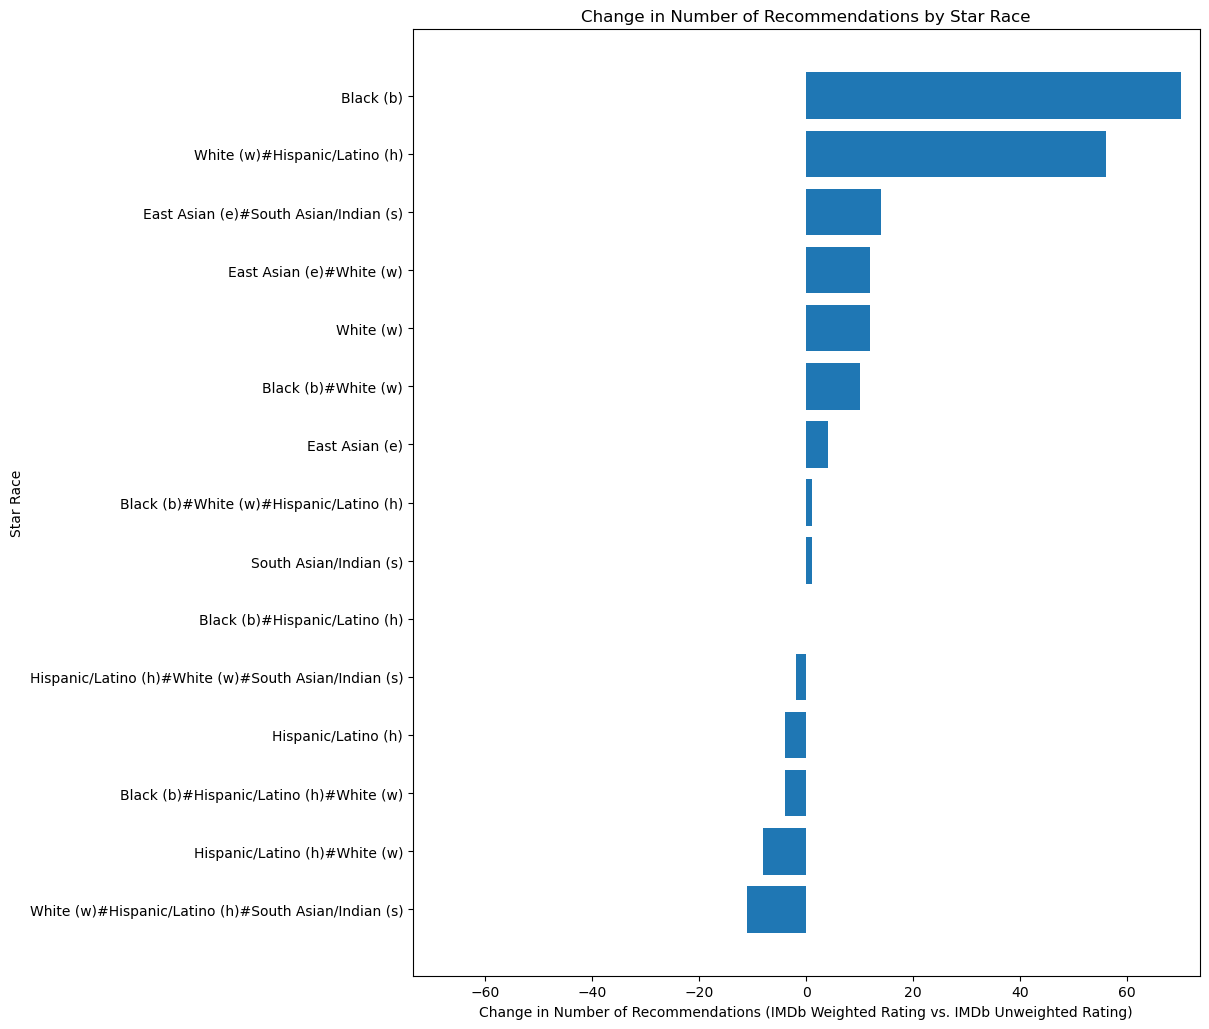

In [522]:
weighted_unweighted_diffed_race_recommendation_df = weighted_unweighted_diffed_race_recommendation_df.sort_values('num_recommendations_diff', ascending=True)

df_to_plot = weighted_unweighted_diffed_race_recommendation_df

plt.figure(figsize=(12, 10))
plt.barh(df_to_plot['race'], df_to_plot['num_recommendations_diff'])
max_abs_value = df_to_plot['num_recommendations_diff'].abs().max() * 1.05
plt.xlim(-max_abs_value, max_abs_value)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.ylabel('Star Race')
plt.xlabel('Change in Number of Recommendations (IMDb Weighted Rating vs. IMDb Unweighted Rating)')
plt.title('Change in Number of Recommendations by Star Race')
plt.show()

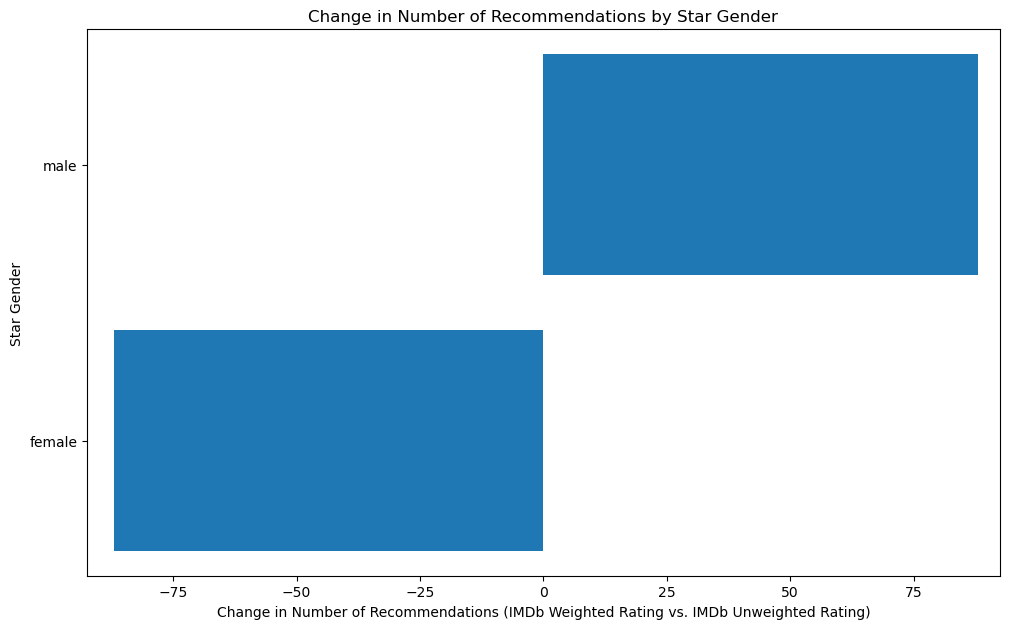

In [497]:
weighted_unweighted_diffed_gender_recommendation_df = weighted_unweighted_diffed_gender_recommendation_df.sort_values('num_recommendations_diff', ascending=True)

df_to_plot = weighted_unweighted_diffed_gender_recommendation_df

plt.figure(figsize=(10, 6))
plt.barh(df_to_plot['gender'], df_to_plot['num_recommendations_diff'])
max_abs_value = df_to_plot['num_recommendations_diff'].abs().max() * 1.05
plt.xlim(-max_abs_value, max_abs_value)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.ylabel('Star Gender')
plt.xlabel('Change in Number of Recommendations (IMDb Weighted Rating vs. IMDb Unweighted Rating)')
plt.title('Change in Number of Recommendations by Star Gender')
plt.show()